In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objects as go 
import plotly.io as pio 
import plotly.colors as colors

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Set the maximum number of columns to display
pd.options.display.max_columns = None
# Set the maximum number of rows to display
pd.options.display.max_rows = 10

plt.rc("figure", figsize=(22, 8))

pd.set_option('display.max_rows', 100) 


In [53]:
file_path = './Data/E-commerce_data.xlsx' 
excel_data = pd.ExcelFile(file_path)

sheet_names = excel_data.sheet_names
print(sheet_names)

['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']


In [54]:
customers  = pd.read_excel(file_path, sheet_name='customers')
genders  = pd.read_excel(file_path, sheet_name='genders')
cities  = pd.read_excel(file_path, sheet_name='cities')
transactions  = pd.read_excel(file_path, sheet_name='transactions')
branches  = pd.read_excel(file_path, sheet_name='branches')
merchants  = pd.read_excel(file_path, sheet_name='merchants')

## Data Understanding & Exploration


In [55]:
customers.head()

,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1


In [56]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6


In [57]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  1000 non-null   int64         
 1   join_date    1000 non-null   datetime64[ns]
 2   city_id      1000 non-null   int64         
 3   gender_id    1000 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 31.4 KB


In [58]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 273.6+ KB


## Data Preprocessing


### Create New Features


In [59]:
# Ensure date columns are in datetime format
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], errors='coerce')
transactions['burn_date'] = pd.to_datetime(transactions['burn_date'], errors='coerce')
customers['join_date'] = pd.to_datetime(customers['join_date'])

transactions['customer_tenure'] = (transactions['transaction_date'] - customers['join_date']).dt.days
customer_tenure = transactions.groupby('customer_id')['customer_tenure'].max().reset_index(name='customer_tenure')

# Recency: Days since last transaction
recent_date = transactions['transaction_date'].max()
recency = transactions.groupby('customer_id')['transaction_date'].max().reset_index(name='last_transaction_date')
recency['recency'] = (recent_date - recency['last_transaction_date']).dt.days
recency = recency[['customer_id', 'recency']]

# Frequency: Total number of transactions
frequency = transactions.groupby('customer_id').size().reset_index(name='transaction_count')


# Total Coupons Claimed and Burnt
coupon_usage_count = transactions[transactions['transaction_status'] == 'subscribed'].groupby('customer_id').size().reset_index(name='coupon_usage_count')
total_coupons_burnt = transactions[transactions['transaction_status'] == 'burned'].groupby('customer_id').size().reset_index(name='total_coupons_burnt')


# Customer Tenure
customers['tenure'] = (recent_date - customers['join_date']).dt.days

# Average time to burn a coupon
transactions['time_to_burn'] = (transactions['burn_date'] - transactions['transaction_date']).dt.days
avg_time_to_burn = transactions.groupby('customer_id')['time_to_burn'].mean().reset_index(name='average_time_to_burn')


# Coupon Redemption Rate
coupon_redemption_rate = total_coupons_burnt.merge(coupon_usage_count, on='customer_id', how='left')
coupon_redemption_rate.fillna(0, inplace=True)
coupon_redemption_rate['redemption_rate'] = coupon_redemption_rate['total_coupons_burnt'] / coupon_redemption_rate['coupon_usage_count']
coupon_redemption_rate['redemption_rate'].replace(np.inf, 0, inplace=True)  # Handle division by zero

# Merge all features into the main DataFrame
customers_features = customers.merge(recency, on='customer_id', how='left')
customers_features = customers_features.merge(frequency, on='customer_id', how='left')
customers_features = customers_features.merge(coupon_usage_count, on='customer_id', how='left')
customers_features = customers_features.merge(total_coupons_burnt, on='customer_id', how='left')
customers_features = customers_features.merge(coupon_redemption_rate[['customer_id', 'redemption_rate']], on='customer_id', how='left')
customers_features = customers_features.merge(avg_time_to_burn, on='customer_id', how='left')
customers_features = customers_features.merge(customer_tenure, on='customer_id', how='left')

# Fill NaN values with 0 (or appropriate values based on business logic)
customers_features.fillna(0, inplace=True)

In [60]:
customers_features.columns

Index(['customer_id', 'join_date', 'city_id', 'gender_id', 'tenure', 'recency',
       'transaction_count', 'coupon_usage_count', 'total_coupons_burnt',
       'redemption_rate', 'average_time_to_burn', 'customer_tenure'],
      dtype='object')

In [61]:
# Fill missing values
customers_features['coupon_usage_count'].fillna(0, inplace=True)
customers_features['transaction_count'].fillna(0, inplace=True)

# Check for any other remaining missing values
print(customers_features.isnull().sum())


customer_id             0
join_date               0
city_id                 0
gender_id               0
tenure                  0
recency                 0
transaction_count       0
coupon_usage_count      0
total_coupons_burnt     0
redemption_rate         0
average_time_to_burn    0
customer_tenure         0
dtype: int64


### Select Features


In [62]:
# One-hot encode categorical features
# customers_features = pd.get_dummies(customers_features, columns=['gender_name', 'city_name'], drop_first=True)

# Select the relevant features for segmentation
segmentation_features = customers_features[['tenure', 'recency', 'transaction_count',
       'coupon_usage_count', 'total_coupons_burnt', 'redemption_rate',
       'average_time_to_burn', 'customer_tenure'] ]


# Fill missing values with 0 (if not already done)
segmentation_features.fillna(0, inplace=True)


In [63]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Assuming you have a target variable for demonstration purposes
# In an unsupervised setting, you might skip this step or use a proxy target
# For demonstration, create a synthetic binary target variable
np.random.seed(0)
segmentation_features['target'] = np.random.randint(0, 2, size=len(segmentation_features))

# Train a RandomForestClassifier
X = segmentation_features.drop('target', axis=1)
y = segmentation_features['target']
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

importance_df


,feature,importance
0,tenure,0.218612
1,recency,0.197923
6,average_time_to_burn,0.175753
7,customer_tenure,0.137889
2,transaction_count,0.078356
5,redemption_rate,0.076085
3,coupon_usage_count,0.060926
4,total_coupons_burnt,0.054454


In [64]:
# Define the number of top features to select
num_top_features = 5

# Select top features based on importance
top_features = importance_df.head(num_top_features)['feature'].tolist()

# Create a DataFrame with only the selected features
X_selected = segmentation_features[top_features]

# Print the selected features
print("Selected top features for clustering:")
print(top_features)


Selected top features for clustering:
['tenure', 'recency', 'average_time_to_burn', 'customer_tenure', 'transaction_count']


In [65]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)


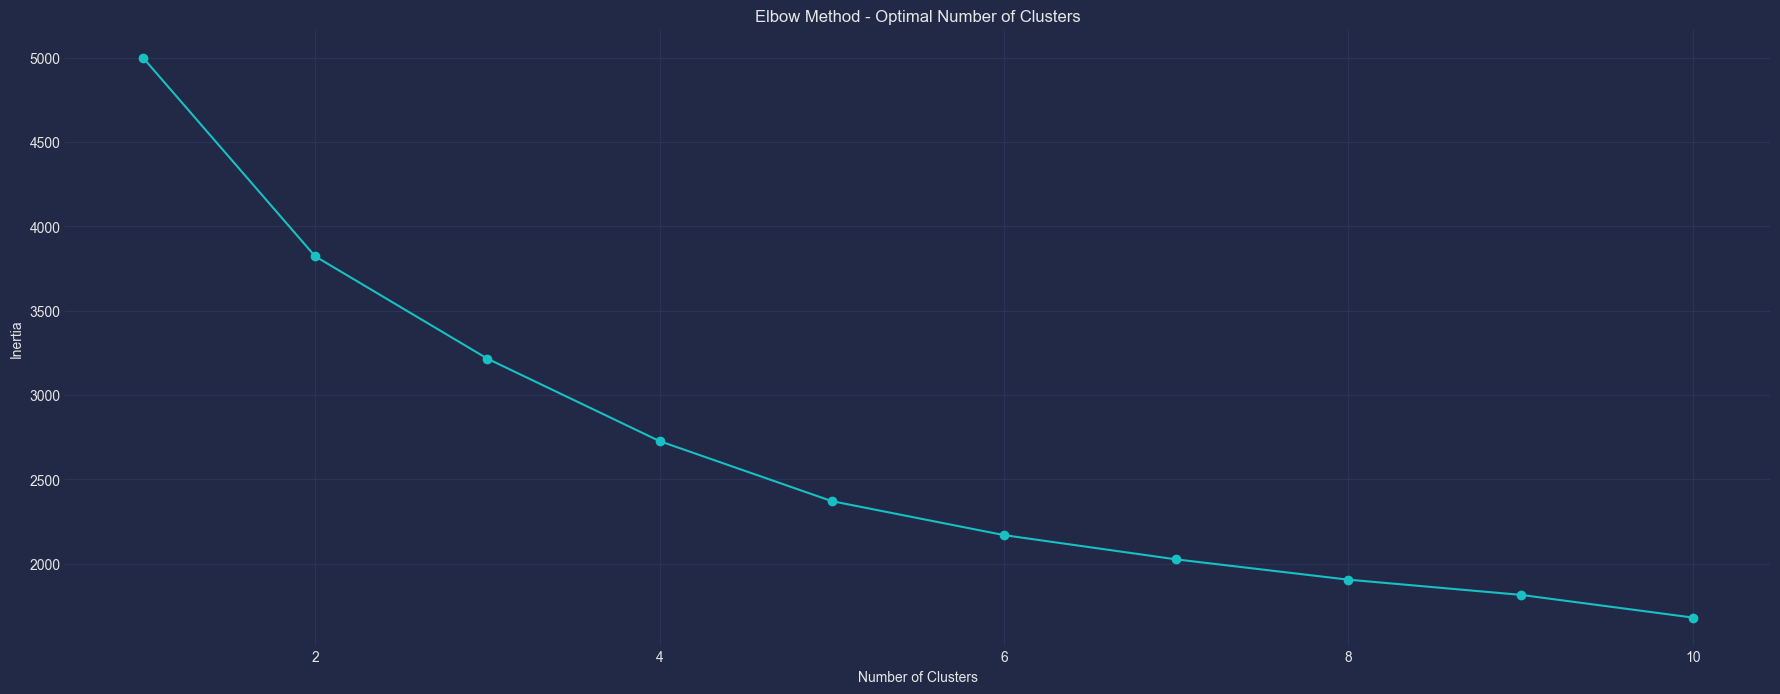

In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_selected_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method - Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [67]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X_selected_scaled)

# Add cluster labels to the original DataFrame
segmentation_features['cluster'] = clusters

# Calculate silhouette score for 5 clusters
silhouette_5 = silhouette_score(X_selected_scaled, segmentation_features['cluster'])
print(f'Silhouette Score for 5 clusters: {silhouette_5}')


Silhouette Score for 5 clusters: 0.21523854141654736


In [68]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(X_selected_scaled)

# Add cluster labels to the original DataFrame
segmentation_features['cluster'] = clusters

# Calculate silhouette score for 5 clusters
silhouette_5 = silhouette_score(X_selected_scaled, segmentation_features['cluster'])
print(f'Silhouette Score for 5 clusters: {silhouette_5}')


Silhouette Score for 5 clusters: 0.22006307046355875


In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Define a range of K values to test
k_values = range(2, 11)  # Test K from 2 to 10

# Split data into training and validation sets
X_train, X_val = train_test_split(X_selected_scaled, test_size=0.2, random_state=0)

# Initialize lists to store results
silhouette_scores = []

# Perform K-Means clustering for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train)
    labels = kmeans.predict(X_val)
    score = silhouette_score(X_val, labels)
    silhouette_scores.append(score)
    print(f'K={k}, Silhouette Score={score:.4f}')


K=2, Silhouette Score=0.2210
K=3, Silhouette Score=0.2139
K=4, Silhouette Score=0.2148
K=5, Silhouette Score=0.2225
K=6, Silhouette Score=0.2039
K=7, Silhouette Score=0.1938
K=8, Silhouette Score=0.2031
K=9, Silhouette Score=0.1956
K=10, Silhouette Score=0.1674


- K=5 has the highest Silhouette Score of 0.2252.


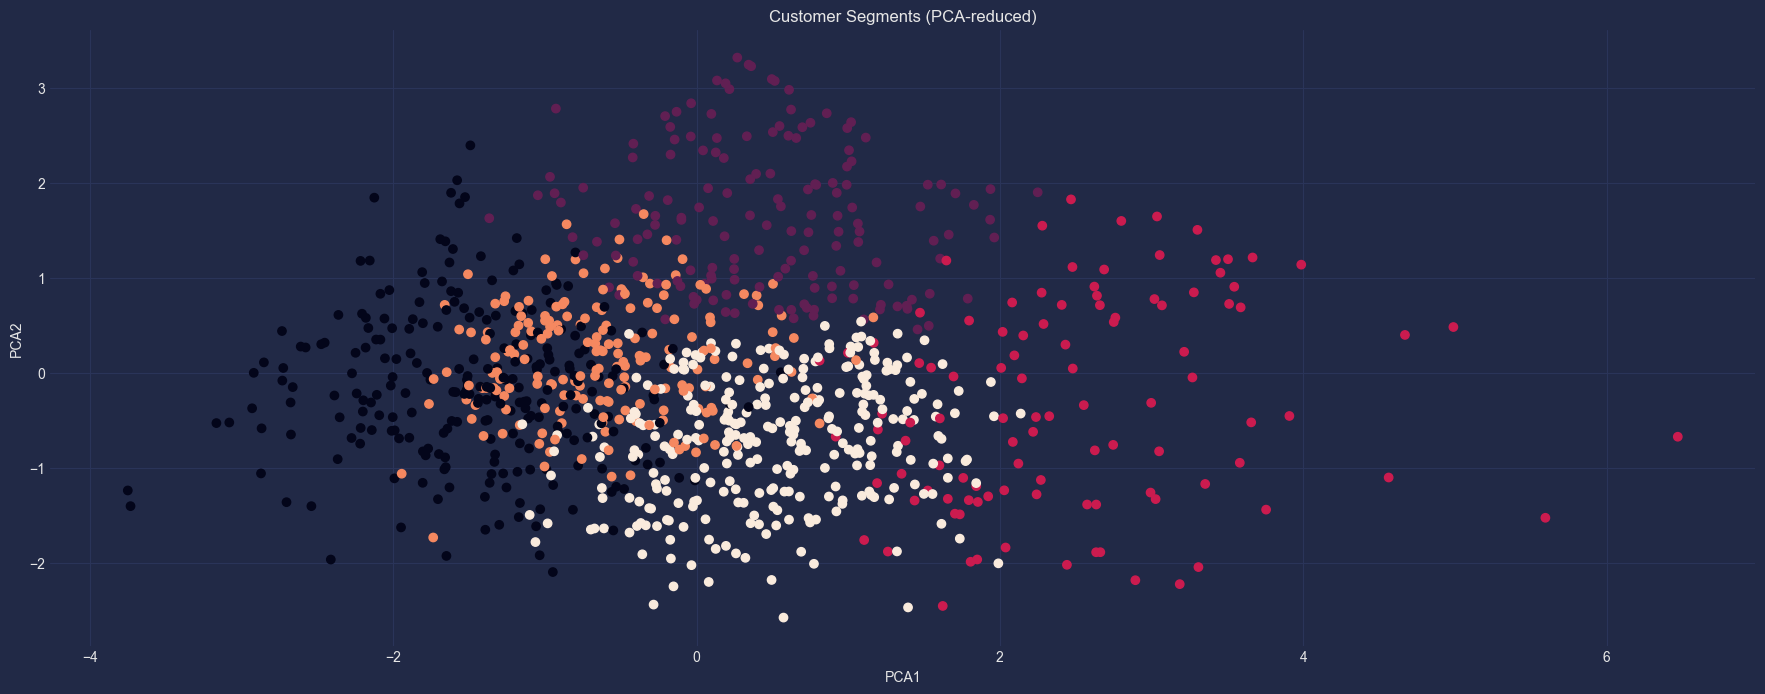

In [70]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=segmentation_features['cluster'], cmap='rocket')
plt.title('Customer Segments (PCA-reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


In [71]:
segmentation_features

,tenure,recency,transaction_count,coupon_usage_count,total_coupons_burnt,redemption_rate,average_time_to_burn,customer_tenure,target,cluster
0,918,49.0,7.0,4.0,3.0,0.75,55.666667,142.0,0,4
1,439,267.0,3.0,2.0,1.0,0.50,4.000000,640.0,1,1
2,427,9.0,5.0,4.0,1.0,0.25,57.000000,691.0,1,0
3,597,546.0,1.0,1.0,0.0,0.00,0.000000,0.0,0,2
4,445,12.0,4.0,1.0,3.0,3.00,55.000000,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...
995,625,66.0,3.0,3.0,0.0,0.00,0.000000,0.0,0,1
996,738,173.0,3.0,2.0,1.0,0.50,17.000000,398.0,0,1
997,127,17.0,4.0,1.0,3.0,3.00,59.666667,0.0,0,3
998,729,96.0,4.0,0.0,4.0,0.00,53.500000,-344.0,1,4


In [72]:
# Descriptive statistics for each cluster
cluster_stats = segmentation_features.groupby('cluster').agg({
    'tenure': ['mean', 'std'],
    'recency': ['mean', 'std'],
    'transaction_count': ['mean', 'std'],
    'coupon_usage_count': ['mean', 'std'],
    'total_coupons_burnt': ['mean', 'std'],
    'redemption_rate': ['mean', 'std'],
    'average_time_to_burn': ['mean', 'std'],
    'customer_tenure': ['mean', 'std']
}).reset_index()

cluster_stats


cluster      tenure                 recency             transaction_count  \
                 mean         std        mean         std              mean   
0       0  385.096000  259.950008   42.832000   49.722481          6.604000   
1       1  436.331210  278.452624   72.025478   73.474045          2.834395   
2       2  862.285714  162.464772  420.580952  141.919112          3.019048   
3       3  240.974227  156.991582   42.386598   49.595149          4.659794   
4       4  828.642857  168.419976  103.265306   78.144465          5.724490   

            coupon_usage_count           total_coupons_burnt            \
        std               mean       std                mean       std   
0  2.082434           3.252000  1.617083            3.352000  1.524925   
1  1.458165           1.910828  1.415916            0.923567  1.028700   
2  1.634843           1.371429  1.067502            1.647619  1.216718   
3  1.744787           2.097938  1.337268            2.561856  1.266871   
4  1.973099           2.789116  1.659521            2.935374  1.374775   

  redemption_rate           average_time_to_burn            customer_tenure  \
             mean       std                 mean        std            mean   
0        1.335294  1.176685            42.584205  15.777591      717.428000   
1        0.512420  0.835640            10.548832  12.041181      121.891720   
2        0.905714  1.024656            36.647188  26.399110       20.533333   
3        1.340292  1.218518            55.619489  14.749668      111.458763   
4        1.302405  1.248059            45.143452  16.529414       50.047619   

               
          std  
0  196.372640  
1  254.587086  
2  282.685850  
3  221.348835  
4  222.619767

In [73]:
customers.columns

Index(['customer_id', 'join_date', 'city_id', 'gender_id', 'tenure'], dtype='object')

In [74]:
segmentation_features.columns

Index(['tenure', 'recency', 'transaction_count', 'coupon_usage_count',
       'total_coupons_burnt', 'redemption_rate', 'average_time_to_burn',
       'customer_tenure', 'target', 'cluster'],
      dtype='object')

### Merge To Aanlysis


In [75]:
segmentation_features.drop(columns=['tenure'],inplace=True)
df = pd.concat([customers, segmentation_features], axis=1)
df

,customer_id,join_date,city_id,gender_id,tenure,recency,transaction_count,coupon_usage_count,total_coupons_burnt,redemption_rate,average_time_to_burn,customer_tenure,target,cluster
0,1,2022-01-08,7,1,918,49.0,7.0,4.0,3.0,0.75,55.666667,142.0,0,4
1,2,2023-05-02,20,2,439,267.0,3.0,2.0,1.0,0.50,4.000000,640.0,1,1
2,3,2023-05-14,15,1,427,9.0,5.0,4.0,1.0,0.25,57.000000,691.0,1,0
3,4,2022-11-25,11,2,597,546.0,1.0,1.0,0.0,0.00,0.000000,0.0,0,2
4,5,2023-04-26,8,1,445,12.0,4.0,1.0,3.0,3.00,55.000000,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2022-10-28,3,1,625,66.0,3.0,3.0,0.0,0.00,0.000000,0.0,0,1
996,997,2022-07-07,20,2,738,173.0,3.0,2.0,1.0,0.50,17.000000,398.0,0,1
997,998,2024-03-09,11,2,127,17.0,4.0,1.0,3.0,3.00,59.666667,0.0,0,3
998,999,2022-07-16,6,1,729,96.0,4.0,0.0,4.0,0.00,53.500000,-344.0,1,4


### 1. Cluster Size Analysis


In [80]:
# Cluster distribution
cluster_counts = df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Number of Customers']


In [81]:
cluster_counts

,Cluster,Number of Customers
0,4,294
1,0,250
2,3,194
3,1,157
4,2,105


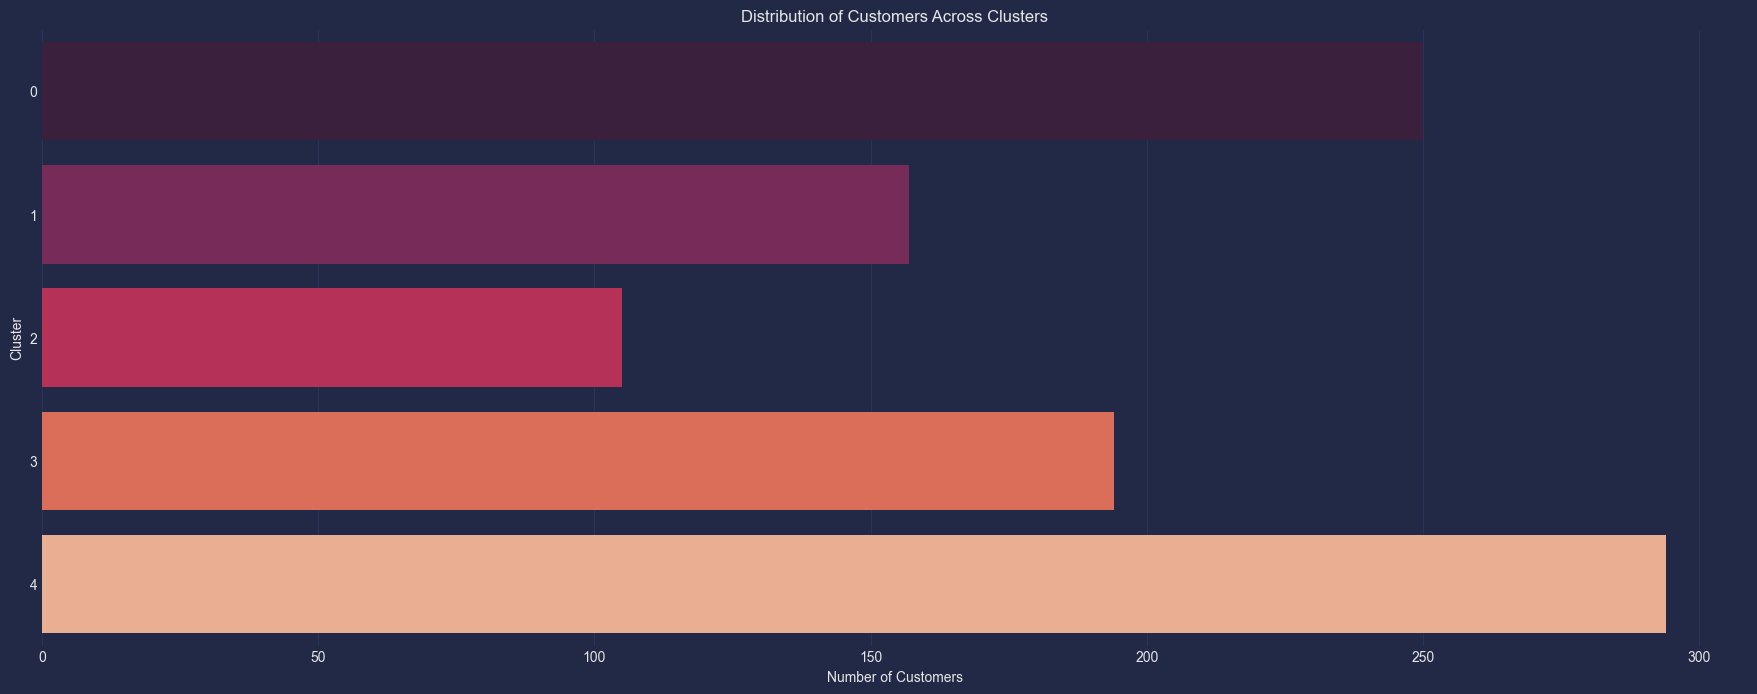

In [84]:
cluster_counts['Cluster'] = cluster_counts['Cluster'].astype('category')
cluster_counts['Cluster'].cat.reorder_categories(cluster_counts['Cluster'], ordered=True, inplace=True)

sns.barplot(x='Number of Customers', y='Cluster', data=cluster_counts, palette='rocket')

# Adding labels and title
plt.xlabel('Number of Customers')
plt.ylabel('Cluster')
plt.title('Distribution of Customers Across Clusters')

# Display the plot
plt.show()


### 2. Demographic Analysis


In [99]:
df['gender'] = df['gender_id'].replace({1: 'male', 2: 'female'})

In [100]:
gender_distribution = df.groupby(['cluster', 'gender']).size().unstack(fill_value=0)
gender_distribution

gender,female,male
cluster,,
0,127,123
1,81,76
2,52,53
3,91,103
4,140,154


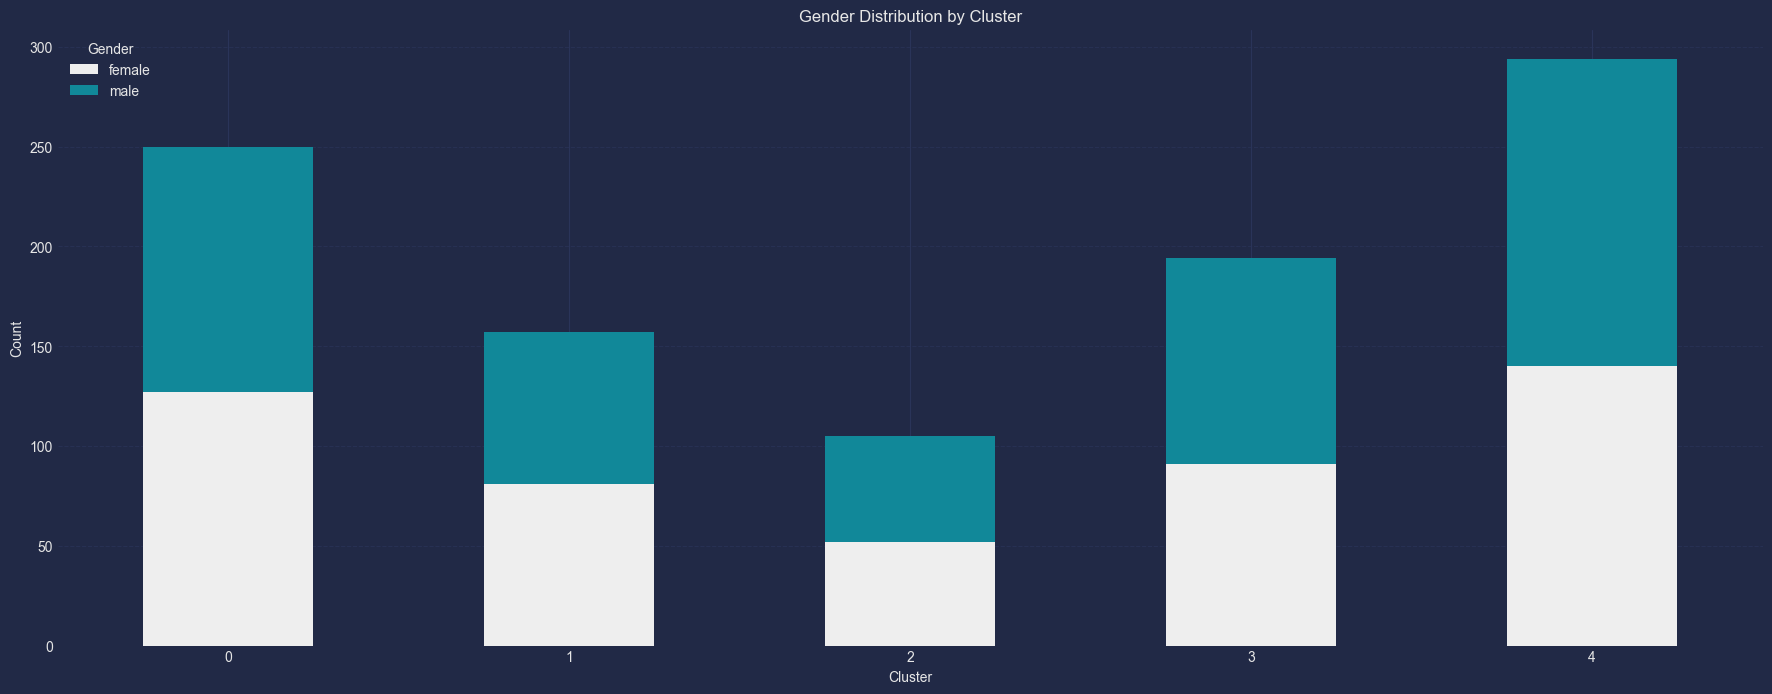

In [110]:
ax = gender_distribution.plot(kind='bar', stacked=True,color=['#eee','#189'])
plt.title('Gender Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)  
plt.show()

In [102]:
df=pd.merge(df,cities)

In [103]:
city_distribution = df.groupby(['cluster', 'city_name']).size().unstack(fill_value=0)
city_distribution


city_name,Alexandria,Aswan,Asyut,Beni Suef,Cairo,Damanhur,Damietta,El-Mahalla El-Kubra,Fayyum,Giza,Ismailia,Mansoura,Minya,Port Said,Qena,Shubra El-Kheima,Sohag,Suez,Tanta,Zagazig
cluster,,,,,,,,,,,,,,,,,,,,
0,15,16,12,7,24,13,7,9,12,18,13,9,8,19,17,13,12,13,5,8
1,8,8,7,5,10,11,8,9,7,5,5,3,6,9,9,10,10,7,8,12
2,5,2,3,3,4,5,3,13,5,7,3,3,3,7,10,11,4,3,6,5
3,7,11,4,8,9,13,6,14,6,9,9,12,11,12,6,10,7,13,19,8
4,13,20,16,13,20,13,17,12,21,19,11,16,16,17,13,8,14,12,7,16


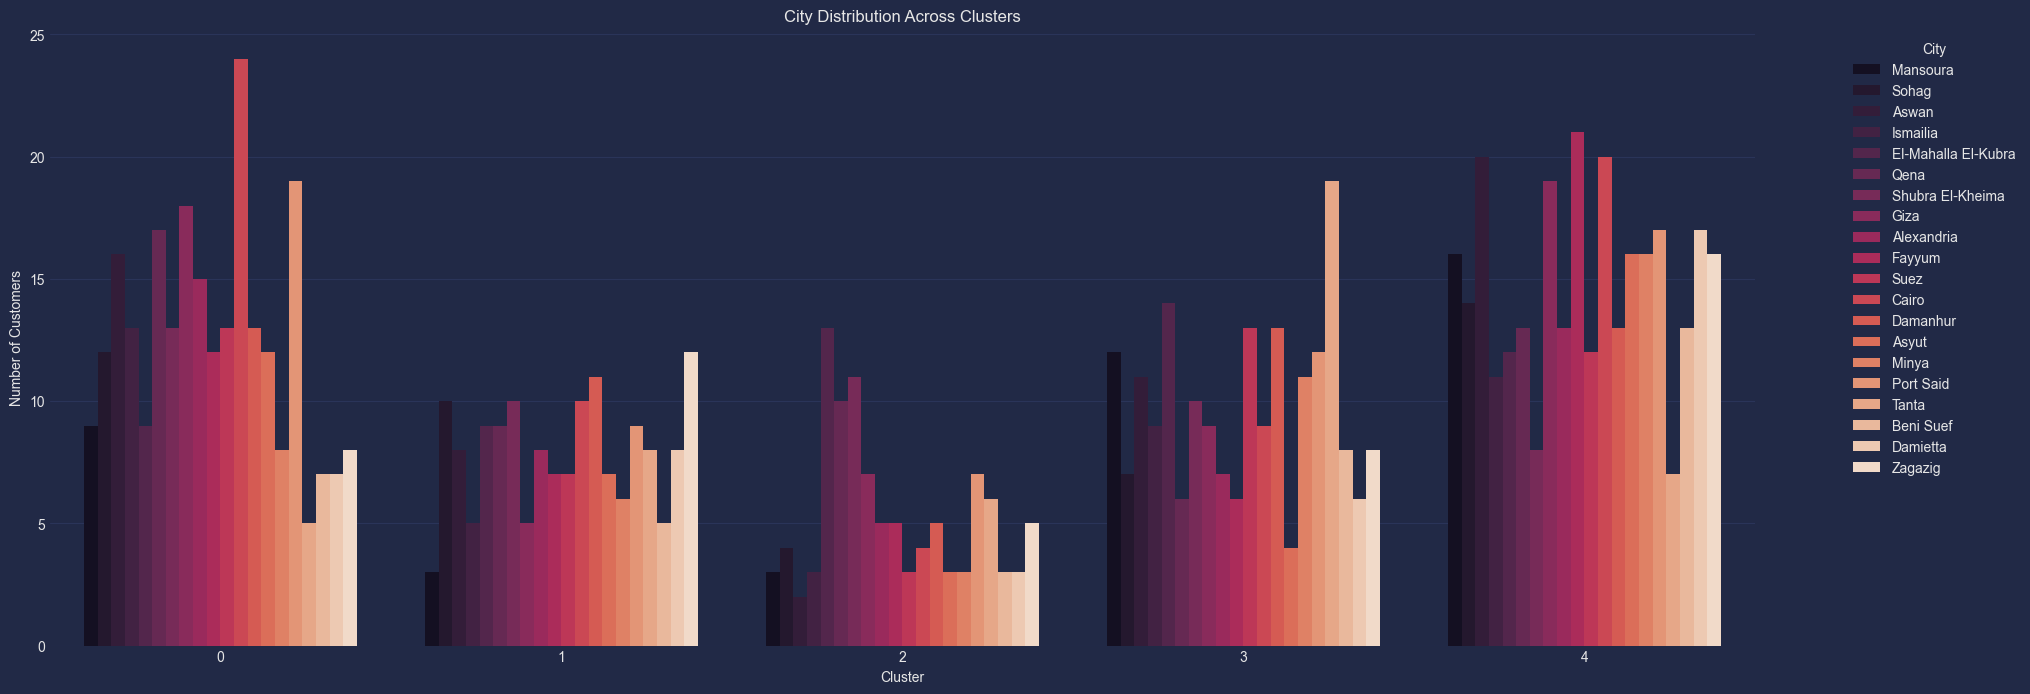

In [136]:
sns.countplot(data=df, x='cluster', hue='city_name', palette='rocket')
plt.title('City Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

Based on the table showing the distribution of customers across different cities and clusters, here are some observations:

1. **Cluster Distribution by City**:
   - **Cluster 0**: Shows a relatively balanced distribution across various cities, with Cairo and Giza having higher counts.
   - **Cluster 1**: Generally has lower counts across cities, with a notable concentration in Cairo and Alexandria.
   - **Cluster 2**: Has a high concentration in Damietta and Cairo, and fewer in cities like Aswan and Asyut.
   - **Cluster 3**: Shows diverse distribution with higher counts in Damietta, Cairo, and Zagazig, and lower in smaller cities.
   - **Cluster 4**: Has high counts in Cairo, Giza, and Fayyum, with a notably high count in Damietta.

2. **City Insights**:
   - **Cairo**: Appears in the top cities across all clusters, indicating it may be a significant hub or focal point for multiple clusters.
   - **Damietta**: Is prominent in Clusters 2 and 4, suggesting it might have distinct characteristics or trends that align with these clusters.
   - **Giza and Fayyum**: Have high counts in Cluster 4, which might indicate a specific customer profile or behavior in these areas.

3. **Cluster Characteristics**:
   - **Cluster 4**: Seems to have the most balanced and high representation across several cities, which might indicate a broad or general customer base.
   - **Cluster 2**: Shows a skew towards certain cities, suggesting it might represent a more specific or niche customer profile.
   - **Cluster 1**: Has lower counts and could represent a less common or less dense customer profile.

4. **Strategic Implications**:
   - **Marketing and Outreach**: Tailor marketing strategies based on the cluster distribution in different cities. For instance, cities with high counts in Cluster 4 might benefit from broader, more inclusive marketing campaigns.
   - **Resource Allocation**: Allocate resources or promotions based on cluster distribution to maximize impact. For example, investing in areas with high counts in Cluster 2 might yield better returns.



----

### 3. Customer Behavior Analysis
Explore how customer behavior differs across clusters by analyzing features like transaction count, coupon usage, and redemption rates.

#### Average Transaction Count per Cluster

In [123]:
transaction_avg = df.groupby('cluster')['transaction_count'].mean().reset_index()
transaction_avg


,cluster,transaction_count
0,0,6.604000
1,1,2.834395
2,2,3.019048
3,3,4.659794
4,4,5.724490


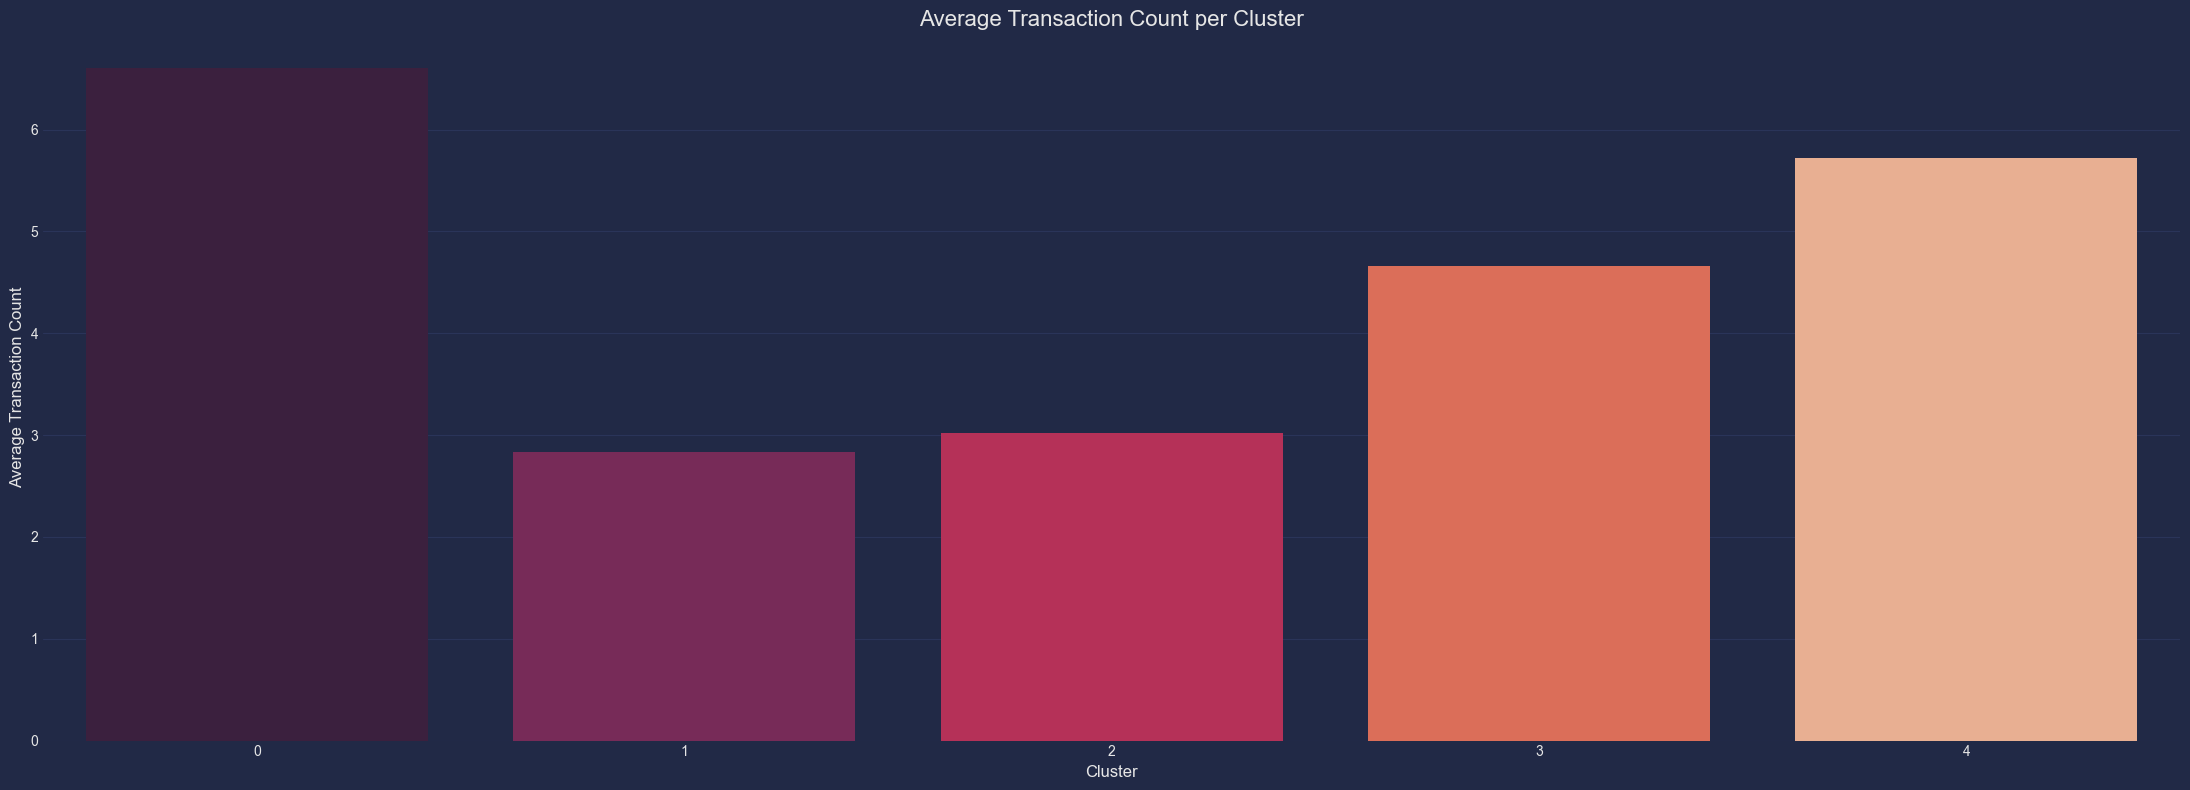

In [124]:
sns.barplot(data=transaction_avg, x='cluster', y='transaction_count', palette='rocket')

# Add titles and labels
plt.title('Average Transaction Count per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Transaction Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Here are the observations based on the transaction counts for each cluster:

1. **Transaction Counts by Cluster**:
   - **Cluster 0**: Highest average transaction count at 6.60.
   - **Cluster 4**: Second highest at 5.72.
   - **Cluster 3**: Average transaction count of 4.66.
   - **Cluster 2**: Lower average at 3.02.
   - **Cluster 1**: Lowest average at 2.83.

2. **Implications**:
   - **Clusters with High Transactions**: Clusters 0 and 4 show higher transaction activity, which may indicate higher engagement or purchasing frequency.
   - **Clusters with Lower Transactions**: Clusters 1 and 2 have lower transaction counts, possibly reflecting less frequent or lower value transactions.

3. **Strategic Insights**:
   - **Focus on High-Value Clusters**: Consider strategies to increase transactions in Clusters 1 and 2, potentially by improving engagement or offering targeted promotions.
   - **Analyze High-Transaction Clusters**: Understand what drives the higher transaction counts in Clusters 0 and 4 to leverage successful strategies across other clusters.


#### Coupon Usage Count per Cluster

In [125]:
coupon_usage_avg = df.groupby('cluster')['coupon_usage_count'].mean().reset_index()
coupon_usage_avg


,cluster,coupon_usage_count
0,0,3.252000
1,1,1.910828
2,2,1.371429
3,3,2.097938
4,4,2.789116


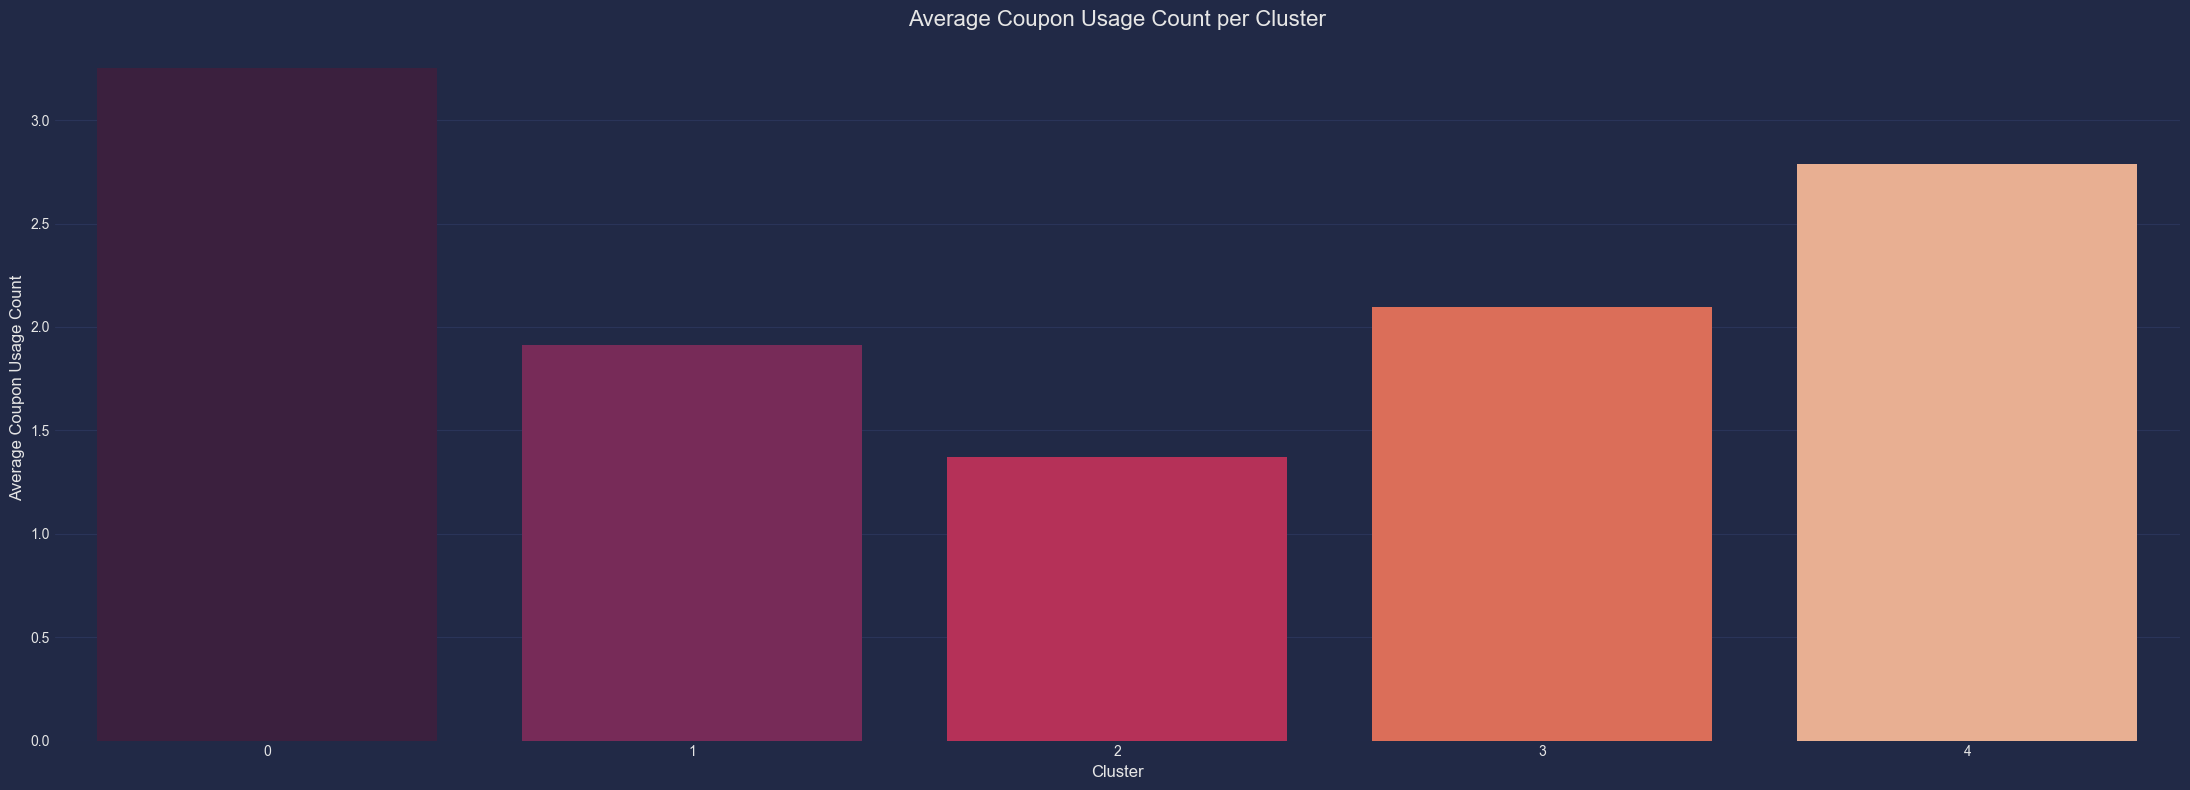

In [127]:
sns.barplot(data=coupon_usage_avg, x='cluster', y='coupon_usage_count', palette='rocket')

# Add titles and labels
plt.title('Average Coupon Usage Count per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Coupon Usage Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Here are the observations based on the coupon usage counts for each cluster:

1. **Coupon Usage by Cluster**:
   - **Cluster 0**: Highest average coupon usage at 3.25.
   - **Cluster 4**: Second highest at 2.79.
   - **Cluster 3**: Average coupon usage of 2.10.
   - **Cluster 1**: Lower average at 1.91.
   - **Cluster 2**: Lowest average at 1.37.

2. **Implications**:
   - **High Coupon Usage Clusters**: Clusters 0 and 4 exhibit higher coupon usage, indicating more frequent use of discounts or promotions.
   - **Lower Coupon Usage Clusters**: Clusters 1 and 2 show less coupon usage, which might suggest lower sensitivity to promotions or different spending behaviors.

3. **Strategic Insights**:
   - **Leverage High Coupon Usage**: Consider enhancing coupon and discount strategies in Clusters 0 and 4 to drive even higher engagement.
   - **Address Low Coupon Usage**: Investigate ways to increase coupon usage in Clusters 1 and 2, possibly by tailoring promotions to better meet their preferences or needs.


#### Redemption Rate per Cluster

In [128]:
redemption_rate_avg = df.groupby('cluster')['redemption_rate'].mean().reset_index()
redemption_rate_avg


,cluster,redemption_rate
0,0,1.335294
1,1,0.512420
2,2,0.905714
3,3,1.340292
4,4,1.302405


Here are the observations based on the redemption rates for each cluster:

1. **Redemption Rates by Cluster**:
   - **Cluster 3**: Highest redemption rate at 1.34.
   - **Cluster 4**: Second highest at 1.30.
   - **Cluster 0**: Close behind with a redemption rate of 1.34.
   - **Cluster 2**: Lower at 0.91.
   - **Cluster 1**: Lowest at 0.51.

2. **Implications**:
   - **High Redemption Clusters**: Clusters 3 and 4 show high redemption rates, suggesting effective use of promotions and potentially high customer engagement with offers.
   - **Lower Redemption Clusters**: Clusters 1 and 2 have lower redemption rates, indicating less frequent or less effective use of promotional offers.

3. **Strategic Insights**:
   - **Enhance Offers for High Redemption**: Build on successful strategies in Clusters 3 and 4 to further boost redemption rates and engagement.
   - **Improve Redemption Strategies**: For Clusters 1 and 2, explore ways to increase redemption rates, such as offering more targeted or appealing promotions.


----

### 4. Recency and Tenure Analysis
Analyze how recently customers have interacted with the company and how long they've been customers.



#### Average Recency per Cluster

In [129]:
recency_avg = df.groupby('cluster')['recency'].mean().reset_index()
recency_avg


,cluster,recency
0,0,42.832000
1,1,72.025478
2,2,420.580952
3,3,42.386598
4,4,103.265306


- High Recency Clusters: Clusters 2 and 4 show lower recent engagement, which might indicate a need for re-engagement strategies or improved customer retention efforts.
- Low Recency Clusters: Clusters 0 and 3 have higher recent engagement, reflecting active customer bases that might be targeted with new promotions or offers.

#### Average Tenure per Cluster

In [130]:
tenure_avg = df.groupby('cluster')['customer_tenure'].mean().reset_index()
tenure_avg


,cluster,customer_tenure
0,0,717.428000
1,1,121.891720
2,2,20.533333
3,3,111.458763
4,4,50.047619


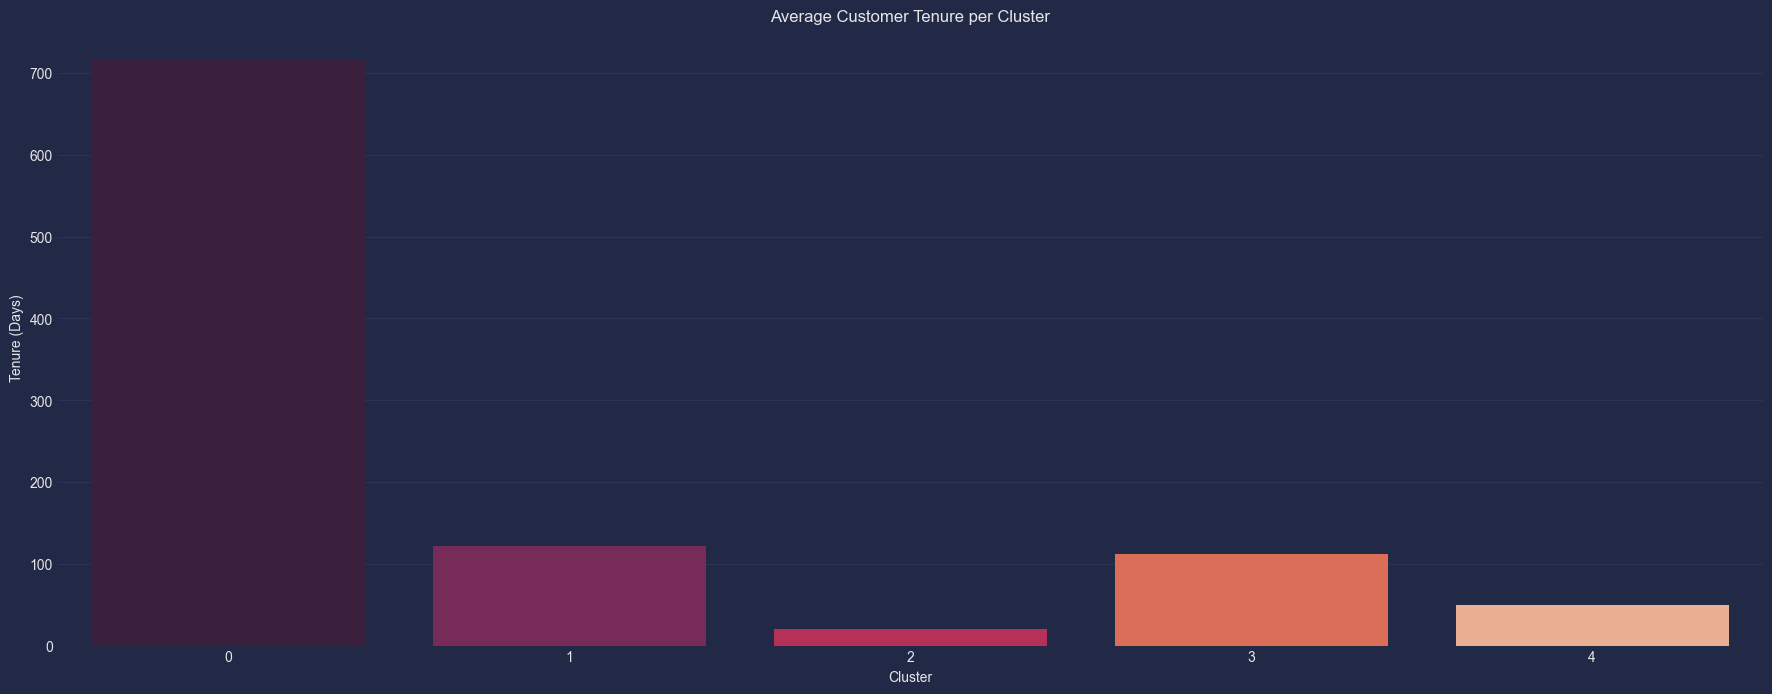

In [140]:
sns.barplot(data=tenure_avg, x='cluster', y='customer_tenure', palette='rocket')
plt.title('Average Customer Tenure per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Tenure (Days)')
plt.show()

- Long-standing Customers: Cluster 0 contains the longest-tenured customers, which could be valuable for loyalty programs or premium offers.
- Newer Customers: Cluster 2 has the shortest tenure, which might benefit from onboarding strategies or introductory offers to boost engagement.

----

### 5. Average Time to Burn Coupons per Cluster

In [131]:
time_to_burn_avg = df.groupby('cluster')['average_time_to_burn'].mean().reset_index()
time_to_burn_avg


,cluster,average_time_to_burn
0,0,42.584205
1,1,10.548832
2,2,36.647188
3,3,55.619489
4,4,45.143452


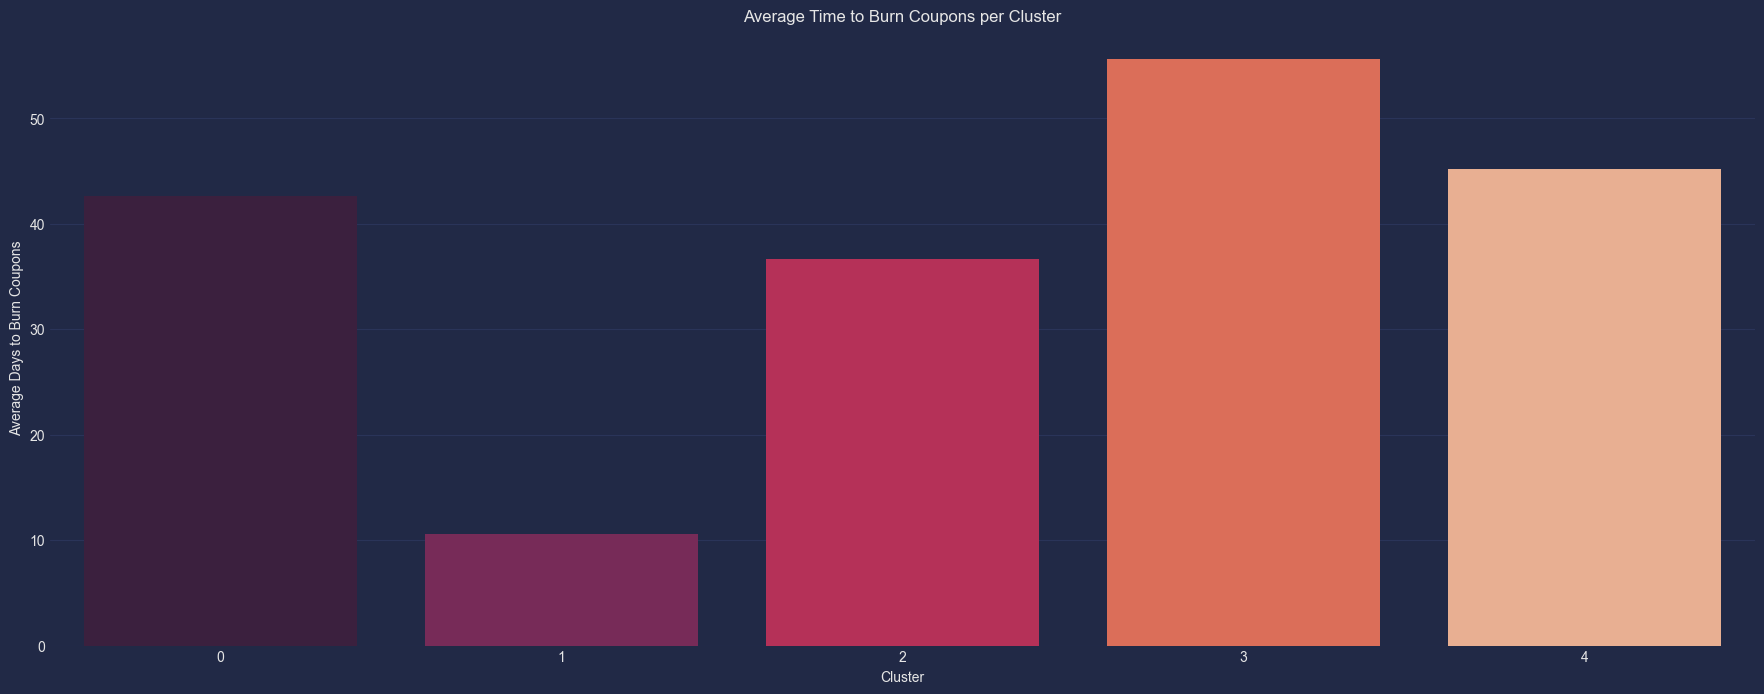

In [142]:
sns.barplot(data=time_to_burn_avg, x='cluster', y='average_time_to_burn', palette='rocket')
plt.title('Average Time to Burn Coupons per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Days to Burn Coupons')
plt.show()

### **Customer Segmentation Analysis Summary**

1. **Cluster Sizes**:
   - **Cluster 0**: 250 customers
   - **Cluster 1**: 157 customers
   - **Cluster 2**: 105 customers
   - **Cluster 3**: 194 customers
   - **Cluster 4**: 294 customers

2. **City Distribution**:
   - **Cluster 4**: Largest number of customers in cities like Cairo, Alexandria, and Giza.
   - **Cluster 0**: Moderate distribution across various cities.
   - **Cluster 1**: More concentrated in cities such as Cairo and Shubra El-Kheima.
   - **Cluster 3**: Fairly distributed, with notable counts in cities like Cairo and Damietta.
   - **Cluster 2**: More evenly spread but with a lower concentration in major cities.

3. **Transaction Count**:
   - **Cluster 0**: Highest average transaction count (6.60).
   - **Cluster 4**: Second highest (5.72).
   - **Cluster 3**: Average (4.66).
   - **Cluster 2**: Lower average (3.02).
   - **Cluster 1**: Lowest (2.83).

4. **Coupon Usage Count**:
   - **Cluster 0**: Highest average coupon usage (3.25).
   - **Cluster 4**: Second highest (2.79).
   - **Cluster 3**: Average (2.10).
   - **Cluster 2**: Lower average (1.37).
   - **Cluster 1**: Lowest (1.91).

5. **Redemption Rate**:
   - **Cluster 3**: Highest redemption rate (1.34).
   - **Cluster 4**: Second highest (1.30).
   - **Cluster 0**: Close behind (1.34).
   - **Cluster 2**: Lower (0.91).
   - **Cluster 1**: Lowest (0.51).

6. **Recency**:
   - **Cluster 2**: Highest recency (420.58), indicating customers haven't engaged recently.
   - **Cluster 4**: Second highest (103.27).
   - **Cluster 1**: Average (72.03).
   - **Cluster 0**: Lower recency (42.83), indicating more recent engagement.
   - **Cluster 3**: Similar to Cluster 0 (42.39).

7. **Customer Tenure**:
   - **Cluster 0**: Highest customer tenure (717.43), indicating very long-standing customers.
   - **Cluster 1**: Second highest (121.89).
   - **Cluster 3**: Slightly lower (111.46).
   - **Cluster 4**: Average tenure (50.05).
   - **Cluster 2**: Lowest tenure (20.53), indicating relatively newer customers.

### **Strategic Insights**
- **High Engagement Clusters**: Focus on retaining and enhancing engagement with customers in Clusters 0 and 3 through loyalty programs and exclusive offers.
- **Low Engagement Clusters**: Develop strategies to boost engagement and retention in Clusters 1, 2, and 4, such as targeted promotions or re-engagement campaigns.
- **Newer Customers**: Implement onboarding strategies to increase the tenure and engagement of customers in Cluster 2.